# Autoencoder

## Libraries

- anndata: 0.10.7
- matplotlib: 3.8.4
- numpy: 1.26.4
- pytorch: 2.2.2 

In [1]:
from dataclasses import dataclass
from random import choice

import anndata as ad
from anndata.experimental import AnnLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Hyperparameters

In [13]:
# Model size
input_layer = 10000
layer_one = 6000
layer_two = 3000
layer_three = 1000
latent_space = 200
# Dataloaders
batch_size = 128
# Optimizer
learning_rate = 1e-1
weight_decay = 1e-8
# Training
folds = 5
epochs = 15

## Model Structure

The **autoencoder** is comprised of two primary components: the **encoder** and the **decoder**. The encoder is responsible for reducing the dimensionality of the input tensor. The decoder, in turn, attempts to reconstruct the original input data from the reduced representation generated by the encoder.

In [3]:
@dataclass
class AEOutput:
    """
    Dataclass for AE output.
    
    Attributes:
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
    """
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor

In [4]:
class Autoencoder(nn.Module):
    """
    Autoencoder (AE) class.

    Args:
        size_input_layer (int): Dimensionality of the input data.
        size_layer_one (int): Dimensionality of hidden layer 1.
        size_layer_two (int): Dimensionality of hidden layer 2.
        size_layer_three (int): Dimensionality of hidden layer 3.
        size_latent_space (int): Dimensionality of the latent space.
    """

    def __init__(
        self,
        size_input_layer: int,
        size_layer_one: int,
        size_layer_two: int,
        size_layer_three: int,
        size_latent_space: int,):
        super(Autoencoder, self).__init__() # Why?

        self.encoder = nn.Sequential(
            nn.Linear(size_input_layer, size_layer_one),
            nn.SiLU(),  # Swish activation function
            nn.Linear(size_layer_one, size_layer_two),
            nn.SiLU(),  # Swish activation function
            nn.Linear(size_layer_two, size_layer_three),
            nn.SiLU(),  # Swish activation function
            nn.Linear(size_layer_three, size_latent_space)
        )

        self.decoder = nn.Sequential(
            nn.Linear(size_latent_space, size_layer_three),
            nn.SiLU(),
            nn.Linear(size_layer_three, size_layer_two),
            nn.SiLU(),
            nn.Linear(size_layer_two, size_layer_one),
            nn.SiLU(),
            nn.Linear(size_layer_one, size_input_layer),   
        )

    def encode(self, x, eps: float = 1e-8):
       """
       Encodes the input data into the latent space.
        
       Args:
           x (torch.Tensor): Input data.
        
       Returns:
           torch.Tensor: Input data compressed to latent space.
       """
       return self.encoder(x)
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the AE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        z = self.encode(x)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return AEOutput(
                z_sample=z,
                x_recon=recon_x,
                loss=None
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        
        return AEOutput(
            z_sample=z,
            x_recon=recon_x,
            loss=loss_recon
        )
       

## Loading the Data

In [20]:
# file_path = "../data/adata_normalized_sample.h5ad"
file_path = "../data/adata_30kx10k_normalized_sample.h5ad"
# file_path = "/home/ubuntu/projects/project_data/thesis/global_raw.h5ad"

adata = ad.read_h5ad(filename=file_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
cuda = True if device == "cuda" else False 

In [22]:
# Does not work yet --> Data type error
# adata.X = adata.layers["min_max_normalized"]

<30000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 12490183 stored elements in Compressed Sparse Row format>

The dataset is divided into two sections: one for training and the other for validation following training. This division is referred to as a **"fold"**. The fold is created by extracting all cells from a single donor to ensure that the results are not influenced by any batch effects specific to that donor.

In [12]:
def create_folds(adata):
    donors = adata.obs["donor"].unique()
    # Random choice for donor
    donor = choice(donors) # --> Is random choice correct

    # Create training data
    # Remove cells from chosen donor
    train_data = adata[adata.obs.donor != donor]
    # Create validation data
    val_data = adata[adata.obs.donor == donor]

    # Load data
    train_loader = AnnLoader(train_data, batch_size=batch_size, shuffle=True, use_cuda=cuda)
    val_loader = AnnLoader(val_data, batch_size=batch_size, shuffle=True, use_cuda=cuda)

    return train_loader, val_loader

## Training

In [14]:
model = Autoencoder(input_layer, layer_one, layer_two, layer_three, latent_space)

In [15]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [23]:
PRINT_LOSS = 100

training_losses = []
for fold in range(folds):
    # Print fold information
    print("# --------------- #")
    print(f"FOLD {fold + 1}")
    print("# --------------- #")
    
    train_loader, val_loader = create_folds(adata)
    
    for epoch in range(epochs):
        model.train(True)
        # Print epoch information
        print(f"Starting EPOCH {epoch + 1} / {epochs}")

        # Holds the running loss
        running_t_loss = 0.
        for idx, batch in enumerate(train_loader):
            # Reconstruct input
            reconstructed = model(batch.X)

            # Calculate batch loss
            t_loss = loss_function(reconstructed, batch.X)

            # Zero gradients
            optimizer.zero_grad()
            # Backprop
            t_loss.backward()
            # Perform optimization
            optimizer.step()

            # Save loss for plotting
            training_losses.append(t_loss.item())

            # For command line info
            running_t_loss += t_loss.item()
            if idx % PRINT_LOSS == (PRINT_LOSS - 1):
                print(f"Avg loss after BATCH {idx + 1}: {running_t_loss / PRINT_LOSS}")
                running_tloss = 0.
    
    # Cmd info
    print("Finished TRAINING process.")
    print("Start TESTING")

    # Model evaluation
    model.eval()
    running_v_loss = 0.
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            reconstructed = model(batch.X)
            v_loss = loss_function(reconstructed, batch.X)
            running_v_loss += v_loss.item()

    print(f"Avg loss in validation FOLD: {running_v_loss / idx + 1}")    

# --------------- #
FOLD 1
# --------------- #
Starting EPOCH 1 / 15
Avg loss after BATCH 100: 1.4210562187037691e+23
Avg loss after BATCH 200: 1.4210562187784177e+23
Starting EPOCH 2 / 15
Avg loss after BATCH 100: 110244999.78099062
Avg loss after BATCH 200: 110245001.20154655
Starting EPOCH 3 / 15


KeyboardInterrupt: 

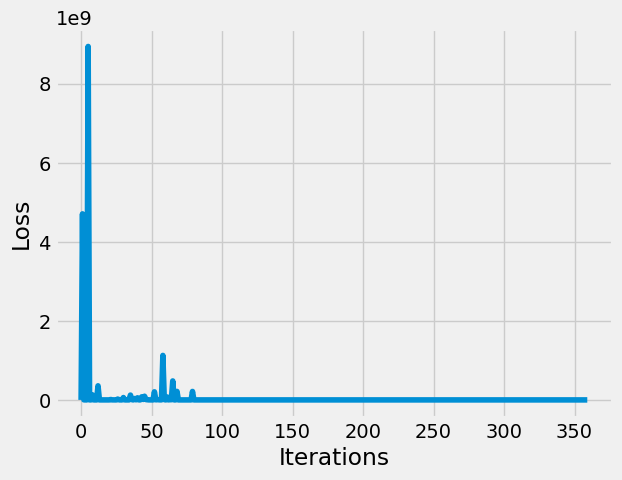

In [13]:
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(training_losses)